In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [48]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

2.4.1+cu124


device(type='cuda')

Helper class to prepare tensor dataset

In [49]:
class setData(Dataset):
    def __init__(self, directory, transform):
        self.data = datasets.ImageFolder(root=directory, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

Preparing data

In [51]:
train_path = 'train'
val_path = 'valid'
test_path = 'test'

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

train_dataset = setData(train_path, transform)
test_dataset = setData(test_path, transform)
val_dataset = setData(val_path, transform)
final_train_dataset = ConcatDataset([train_dataset, test_dataset])
train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)
final_train_data = DataLoader(final_train_dataset, batch_size=32, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=32, shuffle=False)


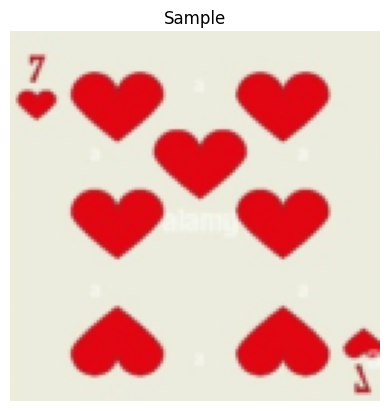

In [52]:
images, labels = next(iter(train_data))
image = np.transpose(images[1].detach(), (1,2,0))
plt.figure()
plt.title('Sample')
plt.axis('off')
plt.imshow(image)

Defining Model

In [62]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8,
                      kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            #nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32,
                      stride=1, kernel_size=5, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            #nn.Dropout(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      stride=1, kernel_size=5, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            #nn.Dropout(0.2)
        )
        self.out = nn.Linear(576, 53)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


In [63]:
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 100
train_loss, test_loss, train_acc, test_acc = [], [], [], []

Training phase

In [64]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for X, y in tqdm(train_data, desc=f'Epoch: {epoch+1} / {epochs}', leave=False):
        X = X.to(device)
        y = y.to(device)
        ypred = model(X)
        loss = criterion(ypred, y)
        preds = torch.max(ypred, dim=1)[1]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * X.shape[0]
        running_acc += (y == preds).sum().item()
    acc = (running_acc / train_dataset.__len__()) * 100
    train_acc.append(acc)
    train_loss.append(running_loss)
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for X, y in tqdm(test_data, desc='Testing', leave=False):
            X = X.to(device)
            y = y.to(device)
            ypred = model(X)
            preds = torch.max(ypred, dim=1)[1]
            running_acc += (y == preds).sum().item()
            loss = criterion(ypred, y)
            running_loss += loss.item() * X.shape[0]
        test_loss.append(running_loss)
        acc = (running_acc / test_dataset.__len__()) * 100
        test_acc.append(acc)
    print(f'Epoch: {epoch+1} Train Accuracy: {train_acc[-1]} Test Accuracy: {test_acc[-1]} Train Loss: {train_loss[-1]} Test Loss: {test_loss[-1]}')

Epoch: 1 Train Accuracy: 22.835781741867788 Test Accuracy: 38.113207547169814 Train Loss: 21754.203879356384 Test Loss: 548.9482588768005


Epoch: 2 Train Accuracy: 37.04092339979014 Test Accuracy: 41.132075471698116 Train Loss: 16513.67737007141 Test Loss: 498.3311791419983


Epoch: 3 Train Accuracy: 46.56348373557188 Test Accuracy: 60.75471698113207 Train Loss: 14599.611921310425 Test Loss: 415.3872699737549


Epoch: 4 Train Accuracy: 57.72560335781742 Test Accuracy: 67.16981132075472 Train Loss: 12553.13551902771 Test Loss: 379.2426643371582


Epoch: 5 Train Accuracy: 61.67366211962224 Test Accuracy: 71.69811320754717 Train Loss: 11484.874576568604 Test Loss: 313.85100269317627


Epoch: 6 Train Accuracy: 64.50682056663169 Test Accuracy: 72.0754716981132 Train Loss: 10742.819234848022 Test Loss: 310.3363676071167


Epoch: 7 Train Accuracy: 65.46432318992655 Test Accuracy: 74.71698113207546 Train Loss: 10198.607471466064 Test Loss: 290.73205518722534


Epoch: 8 Train Accuracy: 66.52675760755508 Test Accuracy: 76.60377358490567 Train Loss: 9899.463879585266 Test Loss: 272.62899708747864


Epoch: 9 Train Accuracy: 67.9302203567681 Test Accuracy: 73.9622641509434 Train Loss: 9453.535420417786 Test Loss: 258.3924207687378


Epoch: 10 Train Accuracy: 69.13693599160545 Test Accuracy: 67.54716981132076 Train Loss: 9121.537872314453 Test Loss: 312.31995725631714


Epoch: 11 Train Accuracy: 70.76337880377754 Test Accuracy: 75.47169811320755 Train Loss: 8649.19107055664 Test Loss: 251.251593708992


Epoch: 12 Train Accuracy: 71.9700944386149 Test Accuracy: 75.47169811320755 Train Loss: 8293.244331359863 Test Loss: 270.88202476501465


Epoch: 13 Train Accuracy: 72.40293809024135 Test Accuracy: 81.88679245283019 Train Loss: 8112.775228500366 Test Loss: 210.59760200977325


Epoch: 14 Train Accuracy: 72.80954879328436 Test Accuracy: 83.01886792452831 Train Loss: 7926.571212768555 Test Loss: 202.06098532676697


Epoch: 15 Train Accuracy: 74.2392444910808 Test Accuracy: 82.26415094339623 Train Loss: 7565.658595085144 Test Loss: 213.6440850496292


Epoch: 16 Train Accuracy: 74.69832109129067 Test Accuracy: 82.26415094339623 Train Loss: 7380.890581130981 Test Loss: 196.9598650932312


Epoch: 17 Train Accuracy: 75.56400839454355 Test Accuracy: 85.28301886792453 Train Loss: 7199.327138900757 Test Loss: 186.53671026229858


Epoch: 18 Train Accuracy: 75.28856243441763 Test Accuracy: 83.77358490566039 Train Loss: 7182.90092754364 Test Loss: 204.77645897865295


Epoch: 19 Train Accuracy: 75.6427072402938 Test Accuracy: 88.30188679245283 Train Loss: 6985.589198112488 Test Loss: 167.3658789396286


Epoch: 20 Train Accuracy: 76.67890870933893 Test Accuracy: 84.90566037735849 Train Loss: 6833.918076515198 Test Loss: 167.61013519763947


Epoch: 21 Train Accuracy: 77.03305351521512 Test Accuracy: 85.66037735849056 Train Loss: 6696.804390907288 Test Loss: 183.8096126317978


Epoch: 22 Train Accuracy: 77.400314795383 Test Accuracy: 84.90566037735849 Train Loss: 6559.817992210388 Test Loss: 179.6604824066162


Epoch: 23 Train Accuracy: 77.47901364113326 Test Accuracy: 86.0377358490566 Train Loss: 6415.9416271448135 Test Loss: 213.4255791902542


Epoch: 24 Train Accuracy: 77.898740818468 Test Accuracy: 88.30188679245283 Train Loss: 6262.731950759888 Test Loss: 147.9010992050171


Epoch: 25 Train Accuracy: 78.42339979013641 Test Accuracy: 86.79245283018868 Train Loss: 6241.868612289429 Test Loss: 167.30935907363892


Epoch: 26 Train Accuracy: 78.34470094438615 Test Accuracy: 85.66037735849056 Train Loss: 6207.443592071533 Test Loss: 178.3630336523056


Epoch: 27 Train Accuracy: 78.4102833158447 Test Accuracy: 88.30188679245283 Train Loss: 6098.163849830627 Test Loss: 164.08894634246826


Epoch: 28 Train Accuracy: 78.96117523609654 Test Accuracy: 88.30188679245283 Train Loss: 6123.255140304565 Test Loss: 148.81765127182007


Epoch: 29 Train Accuracy: 79.32843651626443 Test Accuracy: 78.49056603773586 Train Loss: 5832.7771072387695 Test Loss: 210.6568055152893


Epoch: 30 Train Accuracy: 79.48583420776495 Test Accuracy: 89.05660377358491 Train Loss: 5926.704268455505 Test Loss: 153.1755782365799


Epoch: 31 Train Accuracy: 79.9186778593914 Test Accuracy: 86.0377358490566 Train Loss: 5730.498978614807 Test Loss: 149.43682479858398


Epoch: 32 Train Accuracy: 79.17103882476391 Test Accuracy: 85.66037735849056 Train Loss: 5934.876302719116 Test Loss: 178.26343512535095


Epoch: 33 Train Accuracy: 79.9186778593914 Test Accuracy: 88.30188679245283 Train Loss: 5766.039668083191 Test Loss: 139.8538920879364


Epoch: 34 Train Accuracy: 79.94491080797481 Test Accuracy: 88.67924528301887 Train Loss: 5715.698580741882 Test Loss: 128.18190503120422


Epoch: 35 Train Accuracy: 80.44333683105981 Test Accuracy: 89.43396226415095 Train Loss: 5662.615348815918 Test Loss: 127.31073117256165


Epoch: 36 Train Accuracy: 80.4302203567681 Test Accuracy: 90.18867924528303 Train Loss: 5631.140413761139 Test Loss: 135.1655399799347


Epoch: 37 Train Accuracy: 80.74501573976916 Test Accuracy: 89.05660377358491 Train Loss: 5516.471021652222 Test Loss: 151.83580231666565


Epoch: 38 Train Accuracy: 80.99422875131165 Test Accuracy: 90.18867924528303 Train Loss: 5478.195055961609 Test Loss: 111.84755736589432


Epoch: 39 Train Accuracy: 81.00734522560336 Test Accuracy: 90.56603773584906 Train Loss: 5552.200612068176 Test Loss: 129.4961792230606


Epoch: 40 Train Accuracy: 80.78436516264428 Test Accuracy: 84.52830188679246 Train Loss: 5456.239595413208 Test Loss: 181.95069801807404


Epoch: 41 Train Accuracy: 80.75813221406086 Test Accuracy: 89.43396226415095 Train Loss: 5507.52933216095 Test Loss: 132.32647502422333


Epoch: 42 Train Accuracy: 81.72875131164743 Test Accuracy: 90.18867924528303 Train Loss: 5403.087954521179 Test Loss: 122.57264626026154


Epoch: 43 Train Accuracy: 81.51888772298005 Test Accuracy: 87.9245283018868 Train Loss: 5348.126346588135 Test Loss: 165.54244780540466


Epoch: 44 Train Accuracy: 81.23032528856243 Test Accuracy: 89.43396226415095 Train Loss: 5420.10831451416 Test Loss: 137.74008667469025


Epoch: 45 Train Accuracy: 80.5613850996852 Test Accuracy: 84.52830188679246 Train Loss: 5476.387226104736 Test Loss: 154.93051731586456


Epoch: 46 Train Accuracy: 81.0729275970619 Test Accuracy: 86.0377358490566 Train Loss: 5319.511816501617 Test Loss: 133.76984524726868


Epoch: 47 Train Accuracy: 82.14847848898216 Test Accuracy: 91.32075471698113 Train Loss: 5199.8828057050705 Test Loss: 122.04854959249496


Epoch: 48 Train Accuracy: 81.13850996852047 Test Accuracy: 91.69811320754717 Train Loss: 5294.36222076416 Test Loss: 117.6082055568695


Epoch: 49 Train Accuracy: 82.14847848898216 Test Accuracy: 89.43396226415095 Train Loss: 5169.2815799713135 Test Loss: 139.94446516036987


Epoch: 50 Train Accuracy: 81.38772298006296 Test Accuracy: 89.43396226415095 Train Loss: 5267.08357667923 Test Loss: 116.95577919483185


Epoch: 51 Train Accuracy: 81.29590766002099 Test Accuracy: 89.81132075471699 Train Loss: 5294.83128452301 Test Loss: 114.85874533653259


Epoch: 52 Train Accuracy: 81.61070304302204 Test Accuracy: 89.43396226415095 Train Loss: 5262.685206413269 Test Loss: 146.49746310710907


Epoch: 53 Train Accuracy: 81.45330535152151 Test Accuracy: 89.05660377358491 Train Loss: 5299.43026971817 Test Loss: 128.04825377464294


Epoch: 54 Train Accuracy: 81.46642182581321 Test Accuracy: 86.79245283018868 Train Loss: 5184.97518324852 Test Loss: 128.71093434095383


Epoch: 55 Train Accuracy: 81.78121720881427 Test Accuracy: 87.54716981132076 Train Loss: 5272.1246509552 Test Loss: 130.51683974266052


Epoch: 56 Train Accuracy: 81.87303252885624 Test Accuracy: 87.54716981132076 Train Loss: 5258.256334781647 Test Loss: 149.72578877210617


Epoch: 57 Train Accuracy: 81.72875131164743 Test Accuracy: 90.18867924528303 Train Loss: 5189.795956134796 Test Loss: 116.88801836967468


Epoch: 58 Train Accuracy: 81.83368310598111 Test Accuracy: 89.05660377358491 Train Loss: 5143.380242586136 Test Loss: 123.8435949087143


Epoch: 59 Train Accuracy: 81.72875131164743 Test Accuracy: 90.56603773584906 Train Loss: 5185.826968193054 Test Loss: 115.85346388816833


Epoch: 60 Train Accuracy: 82.30587618048268 Test Accuracy: 89.81132075471699 Train Loss: 5104.668266057968 Test Loss: 105.6104074716568


Epoch: 61 Train Accuracy: 82.16159496327387 Test Accuracy: 91.32075471698113 Train Loss: 5056.205388069153 Test Loss: 117.56681245565414


Epoch: 62 Train Accuracy: 81.79433368310598 Test Accuracy: 88.30188679245283 Train Loss: 5212.6480050086975 Test Loss: 126.38802993297577


Epoch: 63 Train Accuracy: 81.97796432318992 Test Accuracy: 90.9433962264151 Train Loss: 5089.7953498363495 Test Loss: 108.44522780179977


Epoch: 64 Train Accuracy: 82.35834207764952 Test Accuracy: 89.43396226415095 Train Loss: 5090.401044845581 Test Loss: 112.36063086986542


Epoch: 65 Train Accuracy: 82.04354669464848 Test Accuracy: 88.67924528301887 Train Loss: 5209.327293872833 Test Loss: 122.48171043395996


Epoch: 66 Train Accuracy: 82.41080797481636 Test Accuracy: 86.79245283018868 Train Loss: 5044.208405017853 Test Loss: 198.88706481456757


Epoch: 67 Train Accuracy: 81.83368310598111 Test Accuracy: 89.43396226415095 Train Loss: 5229.020786762238 Test Loss: 118.64319717884064


Epoch: 68 Train Accuracy: 82.03043022035676 Test Accuracy: 87.9245283018868 Train Loss: 5206.473771095276 Test Loss: 118.50204241275787


Epoch: 69 Train Accuracy: 81.80745015739768 Test Accuracy: 88.30188679245283 Train Loss: 5145.649027824402 Test Loss: 117.56184959411621


Epoch: 70 Train Accuracy: 82.03043022035676 Test Accuracy: 89.81132075471699 Train Loss: 5143.489171504974 Test Loss: 114.48523902893066


Epoch: 71 Train Accuracy: 82.47639034627493 Test Accuracy: 89.43396226415095 Train Loss: 5054.085243701935 Test Loss: 125.31913578510284


Epoch: 72 Train Accuracy: 82.54197271773347 Test Accuracy: 90.18867924528303 Train Loss: 5045.863155841827 Test Loss: 121.88105782866478


Epoch: 73 Train Accuracy: 82.43704092339979 Test Accuracy: 90.9433962264151 Train Loss: 5031.284815788269 Test Loss: 100.15775346755981


Epoch: 74 Train Accuracy: 82.22717733473243 Test Accuracy: 87.54716981132076 Train Loss: 5136.753228187561 Test Loss: 146.10485339164734


Epoch: 75 Train Accuracy: 82.38457502623295 Test Accuracy: 87.54716981132076 Train Loss: 5114.445274353027 Test Loss: 154.03409588336945


Epoch: 76 Train Accuracy: 81.80745015739768 Test Accuracy: 89.05660377358491 Train Loss: 5133.599763870239 Test Loss: 136.8336170911789


Epoch: 77 Train Accuracy: 82.59443861490031 Test Accuracy: 88.67924528301887 Train Loss: 5036.745787143707 Test Loss: 130.5023757815361


Epoch: 78 Train Accuracy: 82.1878279118573 Test Accuracy: 89.05660377358491 Train Loss: 5075.069379806519 Test Loss: 126.15263247489929


Epoch: 79 Train Accuracy: 83.06663168940189 Test Accuracy: 91.69811320754717 Train Loss: 5035.858850955963 Test Loss: 108.64701944589615


Epoch: 80 Train Accuracy: 81.95173137460651 Test Accuracy: 83.39622641509435 Train Loss: 5018.7713804244995 Test Loss: 183.73100304603577


Epoch: 81 Train Accuracy: 82.14847848898216 Test Accuracy: 90.18867924528303 Train Loss: 5024.7483558654785 Test Loss: 116.98832666873932


Epoch: 82 Train Accuracy: 81.50577124868835 Test Accuracy: 91.32075471698113 Train Loss: 5088.873243331909 Test Loss: 120.85205221176147


Epoch: 83 Train Accuracy: 82.47639034627493 Test Accuracy: 90.9433962264151 Train Loss: 4984.470490455627 Test Loss: 118.07508188486099


Epoch: 84 Train Accuracy: 82.39769150052466 Test Accuracy: 90.18867924528303 Train Loss: 5087.345416069031 Test Loss: 119.5361847281456


Epoch: 85 Train Accuracy: 83.02728226652675 Test Accuracy: 87.16981132075472 Train Loss: 4998.944040298462 Test Loss: 137.82102167606354


Epoch: 86 Train Accuracy: 82.4501573976915 Test Accuracy: 87.16981132075472 Train Loss: 4947.148169517517 Test Loss: 147.91253066062927


Epoch: 87 Train Accuracy: 82.200944386149 Test Accuracy: 89.05660377358491 Train Loss: 4993.002286911011 Test Loss: 138.97521102428436


Epoch: 88 Train Accuracy: 82.76495278069255 Test Accuracy: 90.56603773584906 Train Loss: 4958.0073046684265 Test Loss: 104.05479007959366


Epoch: 89 Train Accuracy: 82.24029380902414 Test Accuracy: 90.9433962264151 Train Loss: 5061.548768997192 Test Loss: 101.6243577003479


Epoch: 90 Train Accuracy: 82.05666316894019 Test Accuracy: 88.67924528301887 Train Loss: 5057.782785892487 Test Loss: 125.06444597244263


Epoch: 91 Train Accuracy: 82.72560335781742 Test Accuracy: 90.56603773584906 Train Loss: 4983.825123786926 Test Loss: 114.88400119543076


Epoch: 92 Train Accuracy: 82.85676810073453 Test Accuracy: 86.79245283018868 Train Loss: 4940.038540840149 Test Loss: 150.40980780124664


Epoch: 93 Train Accuracy: 82.38457502623295 Test Accuracy: 87.9245283018868 Train Loss: 5076.565430164337 Test Loss: 126.06141316890717


Epoch: 94 Train Accuracy: 83.25026232948584 Test Accuracy: 89.05660377358491 Train Loss: 4949.118699550629 Test Loss: 109.71464800834656


Epoch: 95 Train Accuracy: 82.69937040923399 Test Accuracy: 90.9433962264151 Train Loss: 4893.293801307678 Test Loss: 124.13459634780884


Epoch: 96 Train Accuracy: 82.35834207764952 Test Accuracy: 87.54716981132076 Train Loss: 5047.587327480316 Test Loss: 154.88896346092224


Epoch: 97 Train Accuracy: 82.67313746065058 Test Accuracy: 81.88679245283019 Train Loss: 4981.969366073608 Test Loss: 162.22267693281174


Epoch: 98 Train Accuracy: 82.13536201469044 Test Accuracy: 89.05660377358491 Train Loss: 5005.229403018951 Test Loss: 121.22218537330627


Epoch: 99 Train Accuracy: 81.9386149003148 Test Accuracy: 89.43396226415095 Train Loss: 5054.643524646759 Test Loss: 108.52311956882477


Epoch: 100 Train Accuracy: 83.3420776495278 Test Accuracy: 88.30188679245283 Train Loss: 4878.612206459045 Test Loss: 135.3347366452217


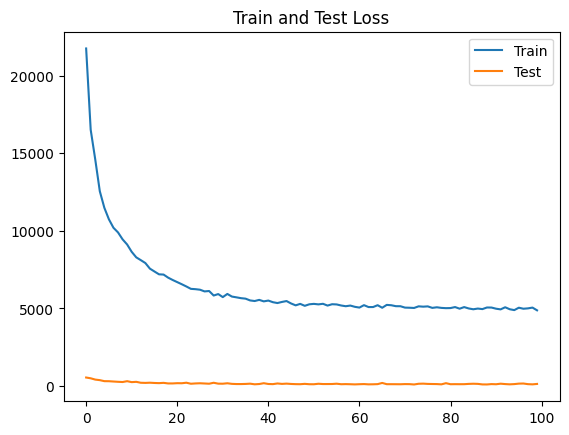

In [65]:
plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), test_loss, label='Test')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

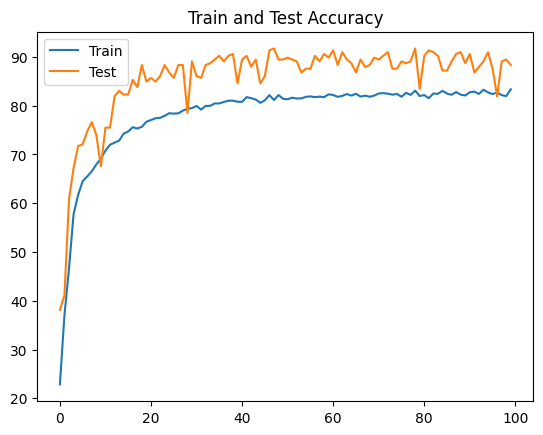

In [66]:
plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), test_acc, label='Test')
plt.legend()
plt.title('Train and Test Accuracy')
plt.show()

Training the model on Train + Test to perform validation

In [67]:
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 100
train_loss, test_loss, train_acc, test_acc = [], [], [], []

In [68]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for X, y in tqdm(final_train_data, desc=f'Epoch: {epoch+1} / {epochs}', leave=False):
        X = X.to(device)
        y = y.to(device)
        ypred = model(X)
        loss = criterion(ypred, y)
        preds = torch.max(ypred, dim=1)[1]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * X.shape[0]
        running_acc += (y == preds).sum().item()
    acc = (running_acc / final_train_dataset.__len__()) * 100
    train_acc.append(acc)
    train_loss.append(running_loss)
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for X, y in tqdm(val_data, desc='Testing', leave=False):
            X = X.to(device)
            y = y.to(device)
            ypred = model(X)
            preds = torch.max(ypred, dim=1)[1]
            running_acc += (y == preds).sum().item()
            loss = criterion(ypred, y)
            running_loss += loss.item() * X.shape[0]
        test_loss.append(running_loss)
        acc = (running_acc / val_dataset.__len__()) * 100
        test_acc.append(acc)
    print(f'Epoch: {epoch+1} Train Accuracy: {train_acc[-1]} Test Accuracy: {test_acc[-1]} Train Loss: {train_loss[-1]} Test Loss: {test_loss[-1]}')

Epoch: 1 Train Accuracy: 23.589808594245152 Test Accuracy: 36.9811320754717 Train Loss: 22702.729942321777 Test Loss: 541.304595708847


Epoch: 2 Train Accuracy: 42.79376346812017 Test Accuracy: 62.264150943396224 Train Loss: 16483.969136476517 Test Loss: 390.9384037256241


Epoch: 3 Train Accuracy: 54.43021929268602 Test Accuracy: 70.56603773584905 Train Loss: 13964.200078129768 Test Loss: 331.0779937505722


Epoch: 4 Train Accuracy: 60.413233616427945 Test Accuracy: 75.47169811320755 Train Loss: 12308.36072230339 Test Loss: 275.2270847558975


Epoch: 5 Train Accuracy: 63.582203067562425 Test Accuracy: 75.09433962264151 Train Loss: 11291.845678687096 Test Loss: 299.88556718826294


Epoch: 6 Train Accuracy: 65.57231588287489 Test Accuracy: 74.33962264150942 Train Loss: 10741.873546421528 Test Loss: 258.973312497139


Epoch: 7 Train Accuracy: 67.7779186208645 Test Accuracy: 78.49056603773586 Train Loss: 10093.18706047535 Test Loss: 241.48724353313446


Epoch: 8 Train Accuracy: 68.5511471669413 Test Accuracy: 75.47169811320755 Train Loss: 9670.34452688694 Test Loss: 284.7814999818802


Epoch: 9 Train Accuracy: 70.19901128153124 Test Accuracy: 79.62264150943396 Train Loss: 9164.055698633194 Test Loss: 204.22102093696594


Epoch: 10 Train Accuracy: 70.64266700469007 Test Accuracy: 82.64150943396227 Train Loss: 8932.744080007076 Test Loss: 216.06419652700424


KeyboardInterrupt: 

In [ ]:
print(train_loss)
plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), test_loss, label='Test')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

In [ ]:
plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), test_acc, label='Test')
plt.legend()
plt.title('Train and Test Accuracy')
plt.show()